In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the cleaned dataset
import pandas as pd
data = pd.read_csv("../Regression Analysis/cleaned_dataset.csv")

# Set up features (X) and target (y)
X = data.drop(columns=['host_is_superhost', 'price_usd'])  # Remove target and irrelevant columns
y = data['host_is_superhost']  # Classification target

# Normalize the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Initialize and train the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Evaluate performance
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and display ROC-AUC
y_prob = dt_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
'''
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
'''
print(f"ROC-AUC Score: {roc_auc:.2f}")

Training set size: (205404, 20), Testing set size: (51351, 20)
Confusion Matrix:
[[36426  5627]
 [ 5307  3991]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     42053
           1       0.41      0.43      0.42      9298

    accuracy                           0.79     51351
   macro avg       0.64      0.65      0.65     51351
weighted avg       0.79      0.79      0.79     51351

ROC-AUC Score: 0.65


In [3]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
dt = DecisionTreeClassifier(random_state=42)

# Randomized Grid Search
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': np.linspace(0.0, 0.1, 5)  # Continuous range for pruning
}

random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=50,  # Test 50 random combinations
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and performance
print("Best parameters found:", random_search.best_params_)
best_dt = random_search.best_estimator_
y_pred_balanced = best_dt.predict(X_test)

# Evaluate the new model
conf_matrix = confusion_matrix(y_test, y_pred_balanced)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced))



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'ccp_alpha': np.float64(0.0)}
Confusion Matrix:
[[34817  7236]
 [ 4759  4539]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     42053
           1       0.39      0.49      0.43      9298

    accuracy                           0.77     51351
   macro avg       0.63      0.66      0.64     51351
weighted avg       0.79      0.77      0.78     51351



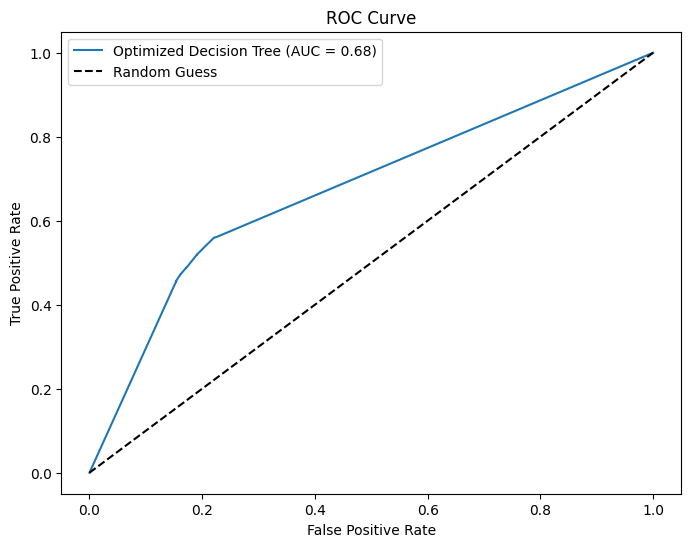

ROC-AUC Score: 0.68


In [4]:
# ROC-AUC for Optimized Model
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_prob_balanced = best_dt.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob_balanced)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_balanced)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Optimized Decision Tree (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.2f}")


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(
    estimator=rf, param_grid=param_grid_rf, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1
)

grid_search_rf.fit(X_train_balanced, y_train_balanced)

# Best parameters
best_rf = grid_search_rf.best_estimator_
print("Best parameters:", grid_search_rf.best_params_)

# Predictions
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = best_rf.predict(X_test)

# Metrics
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

Confusion Matrix:
[[27496 14557]
 [ 2760  6538]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76     42053
           1       0.31      0.70      0.43      9298

    accuracy                           0.66     51351
   macro avg       0.61      0.68      0.60     51351
weighted avg       0.80      0.66      0.70     51351



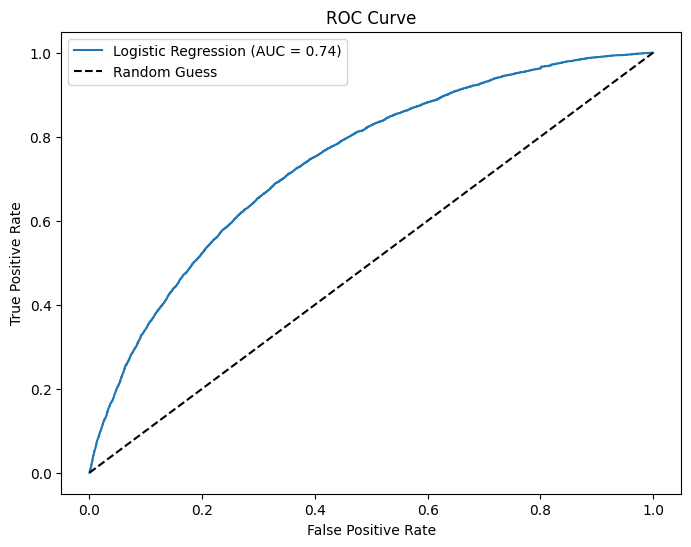

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Logistic Regression with Grid Search
param_grid_lr = {
    'penalty': ['l2'],  # Ridge regression penalty
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['lbfgs'],  # Solver for optimization
    'class_weight': [None, 'balanced']  # Handle class imbalance
}

lr = LogisticRegression(max_iter=500, random_state=42)
grid_search_lr = GridSearchCV(
    estimator=lr, param_grid=param_grid_lr, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1
)

grid_search_lr.fit(X_train_balanced, y_train_balanced)

# Best Logistic Regression Model
best_lr = grid_search_lr.best_estimator_
print("Best parameters:", grid_search_lr.best_params_)

# Predictions
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]
y_pred_lr = best_lr.predict(X_test)

# Metrics
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'lr__C': 100, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}

Confusion Matrix:
[[27494 14559]
 [ 2759  6539]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76     42053
           1       0.31      0.70      0.43      9298

    accuracy                           0.66     51351
   macro avg       0.61      0.68      0.60     51351
weighted avg       0.80      0.66      0.70     51351



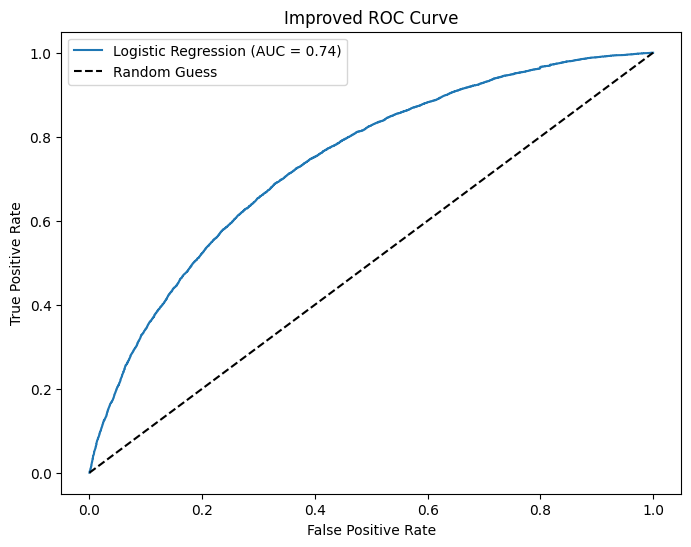

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=500, random_state=42, class_weight='balanced'))
])

# Hyperparameter tuning
param_grid_pipeline = {
    'lr__penalty': ['l2'],
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__solver': ['lbfgs']
}

grid_search_pipeline = GridSearchCV(
    estimator=pipeline, param_grid=param_grid_pipeline, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1
)

grid_search_pipeline.fit(X_train_balanced, y_train_balanced)

# Best Logistic Regression Model
best_pipeline = grid_search_pipeline.best_estimator_
print("Best parameters:", grid_search_pipeline.best_params_)

# Predictions
y_prob_pipeline = best_pipeline.predict_proba(X_test)[:, 1]
y_pred_pipeline = best_pipeline.predict(X_test)

# Metrics
roc_auc_pipeline = roc_auc_score(y_test, y_prob_pipeline)
fpr_pipeline, tpr_pipeline, _ = roc_curve(y_test, y_prob_pipeline)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_pipeline))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_pipeline))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_pipeline, tpr_pipeline, label=f"Logistic Regression (AUC = {roc_auc_pipeline:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Improved ROC Curve")
plt.legend()
plt.show()


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Hyperparameter tuning for SVM with RBF kernel
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 0.1, 0.01],  # Kernel coefficient
    'kernel': ['rbf']  # RBF Kernel
}

svm = SVC(probability=True, random_state=42)
grid_search_svm = GridSearchCV(
    estimator=svm, param_grid=param_grid_svm, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1
)

grid_search_svm.fit(X_train_balanced, y_train_balanced)

# Best SVM Model
best_svm = grid_search_svm.best_estimator_
print("Best parameters:", grid_search_svm.best_params_)

# Predictions
y_prob_svm = best_svm.predict_proba(X_test)[:, 1]
y_pred_svm = best_svm.predict(X_test)

# Metrics
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (RBF Kernel) (AUC = {roc_auc_svm:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for SVM (RBF Kernel)")
plt.legend()
plt.show()


Fitting 5 folds for each of 9 candidates, totalling 45 fits


KeyboardInterrupt: 

In [9]:
# Sort features by importance and select top `k`
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
top_k_features = feature_importance_df.head(10)['Feature'].tolist()  # Adjust '10' for desired number of features

# Reduce feature set
X_train_reduced = X_train_balanced[top_k_features]
X_test_reduced = X_test[top_k_features]


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

# Now you can access feature importances
importances = rf.feature_importances_


In [12]:
# Create a DataFrame for feature importances

import pandas as pd

# Assuming you have column names in a variable `feature_names`
feature_names = X.columns  # Use the original feature names

# Convert numpy array to DataFrame
X_train_balanced = pd.DataFrame(X_train_balanced, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)


feature_importance_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top `k` features (e.g., top 10)
top_k_features = feature_importance_df.head(10)['Feature'].tolist()

# Reduce the dataset to these top features
X_train_reduced = X_train_balanced[top_k_features]
X_test_reduced = X_test[top_k_features]


Confusion Matrix:
[[27402 14651]
 [ 2307  6991]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76     42053
           1       0.32      0.75      0.45      9298

    accuracy                           0.67     51351
   macro avg       0.62      0.70      0.61     51351
weighted avg       0.81      0.67      0.71     51351

ROC-AUC Score: 0.76


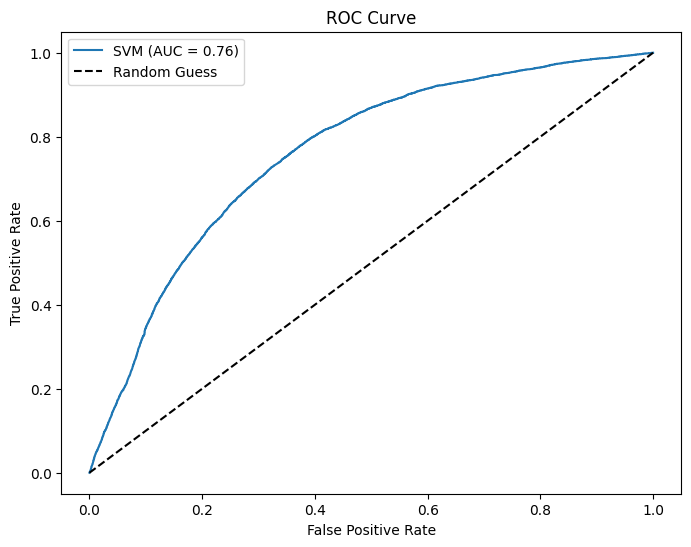

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train the SVM classifier
svm = SVC(kernel='rbf', probability=True, random_state=42)  # You can use other kernels as well
svm.fit(X_train_reduced, y_train_balanced)

# Predict on test data
y_pred = svm.predict(X_test_reduced)
y_prob = svm.predict_proba(X_test_reduced)[:, 1]  # Get probabilities for ROC

# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


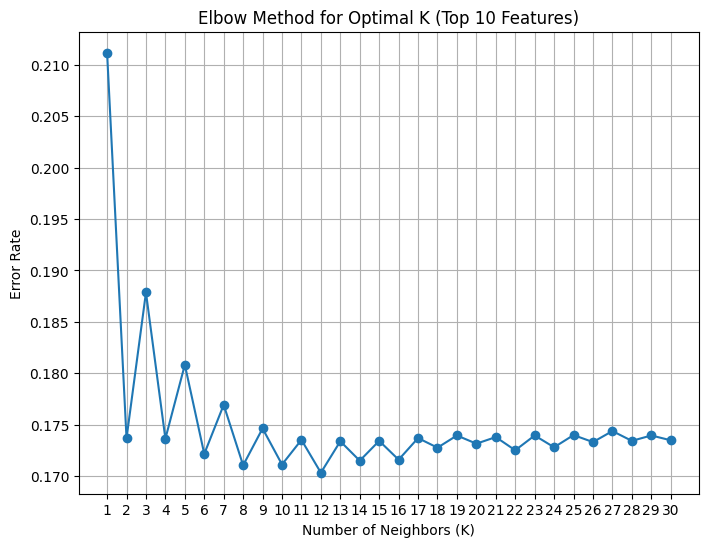

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters found: {'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}
Confusion Matrix:
[[39916  2137]
 [ 6499  2799]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     42053
           1       0.57      0.30      0.39      9298

    accuracy                           0.83     51351
   macro avg       0.71      0.63      0.65     51351
weighted avg       0.81      0.83      0.81     51351


ROC-AUC Score: 0.79


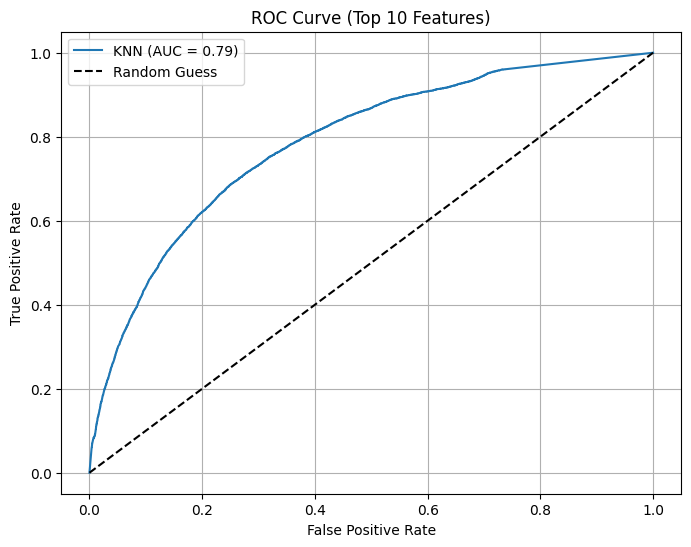

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Select the top 10 features and target column
top_features = ['PC1', 'PC2', 'PC4', 'PC20', 'PC18', 'PC12', 'PC3']
X = data[top_features]
y = data['host_is_superhost']  # Replace 'host_is_superhost' with your target column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 1: Elbow Method to Find Optimal K
error_rates = []
for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    error_rates.append(np.mean(y_pred != y_test))

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 31), error_rates, marker='o')
plt.title('Elbow Method for Optimal K (Top 10 Features)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error Rate')
plt.xticks(range(1, 31))
plt.grid()
plt.show()

# Step 2: Perform Grid Search for Hyperparameter Tuning
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the best KNN model
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)
y_prob = best_knn.predict_proba(X_test_scaled)[:, 1]

# Step 3: Evaluate the Model
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"KNN (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Top 10 Features)')
plt.legend()
plt.grid()
plt.show()

Confusion Matrix (Naive Bayes):
[[20365 21688]
 [ 1987  7311]]

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.91      0.48      0.63     42053
           1       0.25      0.79      0.38      9298

    accuracy                           0.54     51351
   macro avg       0.58      0.64      0.51     51351
weighted avg       0.79      0.54      0.59     51351


ROC-AUC Score (Naive Bayes): 0.69


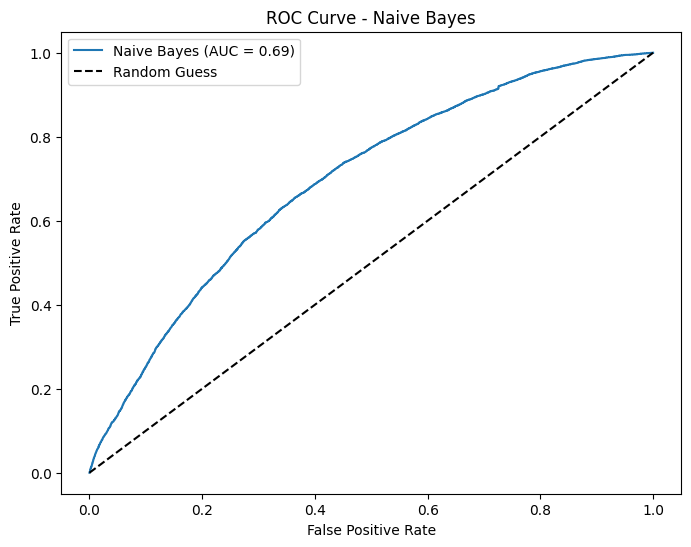

In [16]:
from sklearn.naive_bayes import GaussianNB

X_train_reduced = X_train_balanced[top_features]
X_test_reduced = X_test[top_features]

# Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train_reduced, y_train_balanced)

# Predictions
y_pred_nb = nb.predict(X_test_reduced)
y_prob_nb = nb.predict_proba(X_test_reduced)[:, 1]

# Evaluation
print("Confusion Matrix (Naive Bayes):")
print(confusion_matrix(y_test, y_pred_nb))

print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))

roc_auc_nb = roc_auc_score(y_test, y_prob_nb)
print(f"\nROC-AUC Score (Naive Bayes): {roc_auc_nb:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_nb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Naive Bayes (AUC = {roc_auc_nb:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend()
plt.show()

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the dataset from Kaggle environment
data = pd.read_csv('/kaggle/input/cleaned-dataset-csv/cleaned_dataset.csv')  # Correct path
target = 'host_is_superhost'  # Replace with your target column name

# Separate features and target
X = data.drop(columns=[target])
y = data[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check data dimensions
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Define Neural Network Model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # Adjust the number of epochs
    batch_size=64,  # Adjust batch size based on system capacity
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

# Predictions
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
